# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

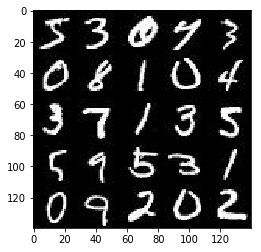

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

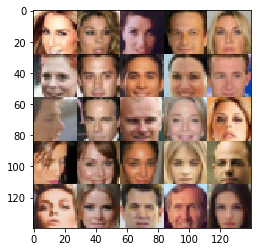

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Layer 1; convloution kernal = 5, subsample stride = 2, 32x32x3 => 16x16x32
        conv1 = tf.layers.conv2d(images, 32, 5, strides=2, activation=None, padding='same', use_bias=False)
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = tf.maximum(alpha*conv1, conv1) # Leaky RELU

        # Layer 2; convloution 16x16x32 => 8x8x64
        conv2 = tf.layers.conv2d(conv1, 64, 5, strides=2, activation=None, padding='same', use_bias=False)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2) # Leaky RELU 

        # Layer 3; convloution 8x8x64 => 4x4x128
        conv3 = tf.layers.conv2d(conv2, 128, 5, strides=2, activation=None, padding='same', use_bias=False)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3) # Leaky RELU

        # flatten the convolution to feed into the fully connected layers
        size = conv3.get_shape().as_list()
        feature_size = size[1]*size[2]*size[3] # get the number of features to fead into the NN 
        flatten = tf.reshape(conv3, (-1, feature_size))
        
        # Layer 4; Fully connect, 32x32x128 = 2048 => 512
        den1 = tf.layers.dense(flatten, feature_size//4, use_bias=False)
        den1 = tf.layers.batch_normalization(den1, training=True)
        den1 = tf.maximum(alpha*den1, den1)
        
        # Layer 5; Fully connect, 512 => 128
        den2 = tf.layers.dense(den1, feature_size//16, use_bias=False)
        den2 = tf.layers.batch_normalization(den2, training=True)
        den2 = tf.maximum(alpha*den2, den2)
        
        # Layer 6; Fully connect, 128 => 1
        logits = tf.layers.dense(den2, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [256]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        alpha=0.2
        """
        # Layer 1; fully connected (z => 8192) => convolution (4 x 4 x 512)
        dens2 = tf.layers.dense(z, 7*7*512)
        conv1 = tf.reshape(dens2, (-1, 7, 7, 512)) # reshape to the first convolution layer
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        # Layer 2; convolution (8 x 8 x 512) => (16 x 16 x 256)
        conv3 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='same', use_bias=False)
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)
        #res2 = tf.image.resize_images(conv3, [16,16])
        
        # Layer 3; convolution (28 x 28 x 128) => (28 x 28 x out_channel_dim)
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, strides=2, padding='same')
        """
        # Dense Layer 1; Fully connect, z => 1024
        #den1 = tf.layers.dense(z, 1024, use_bias=False)
        #den1 = tf.layers.batch_normalization(den1, training=True)
        #den1 = tf.maximum(alpha*den1, den1)
        
        # Layer 1; fully connected (z => 8192) => convolution (4 x 4 x 512)
        dens2 = tf.layers.dense(z, 4*4*512)
        conv1 = tf.reshape(dens2, (-1, 4, 4, 512)) # reshape to the first convolution layer
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        # Layer 2; convolution (4 x 4 x 512) => (8 x 8 x 256)
        conv2 = tf.layers.conv2d_transpose(conv1, 256, 3, strides=2, padding='same', use_bias=False)
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        # Layer 3; convolution (8 x 8 x 256) => (16 x 16 x 128)
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, strides=2, padding='same', use_bias=False)
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)
        
        # Layer 4; convolution (16 x 16 x 128) => (32 x 32 x out_channel_dim)
        conv4 = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.image.resize_images(conv4, [28,28])
        
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [257]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, alpha=0.1)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=0.1)
    
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [258]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    g_vars = [v for v in tf.trainable_variables() if v.name.startswith('generator')]
    d_vars = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1)\
            .minimize(d_loss, var_list=d_vars)
    # https://blog.metaflow.fr/tensorflow-mutating-variables-and-control-flow-2181dd238e62
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1)\
                .minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [259]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [260]:
tf.reset_default_graph()

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    inputs_real, inputs_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)  
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # create tensorboard session at location log_path and save the graph there
        log_path = '/tmp/tensorboard/data/mnist'
        writer = tf.summary.FileWriter(log_path, graph=sess.graph)
    
        for epoch_i in range(epoch_count):
            for image in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                image = image*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(100, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: image, inputs_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, learn_rate: learning_rate})
                #_ = sess.run(g_opt, feed_dict={inputs_z: batch_z, learn_rate: learning_rate})
                
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: image})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 200 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
                    
        # display rge output of the trained network
        show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode) 
        
        print("\nFinished")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5944... Generator Loss: 0.4695
Epoch 1/2... Discriminator Loss: 1.5510... Generator Loss: 0.4748
Epoch 1/2... Discriminator Loss: 1.4939... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.4437... Generator Loss: 0.5500
Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 0.5848
Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 0.6271
Epoch 1/2... Discriminator Loss: 1.3584... Generator Loss: 0.6530
Epoch 1/2... Discriminator Loss: 1.2884... Generator Loss: 0.6885
Epoch 1/2... Discriminator Loss: 1.2524... Generator Loss: 0.7225
Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 0.7454


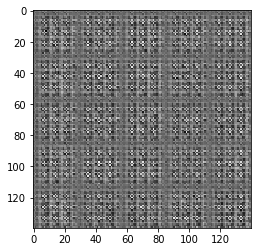

Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.2051... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.1436... Generator Loss: 0.8359
Epoch 1/2... Discriminator Loss: 1.1176... Generator Loss: 0.8755
Epoch 1/2... Discriminator Loss: 1.1156... Generator Loss: 0.8949
Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 0.9167
Epoch 1/2... Discriminator Loss: 1.0984... Generator Loss: 0.9692
Epoch 1/2... Discriminator Loss: 1.0957... Generator Loss: 0.9568
Epoch 1/2... Discriminator Loss: 1.0500... Generator Loss: 0.9295
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 0.8464


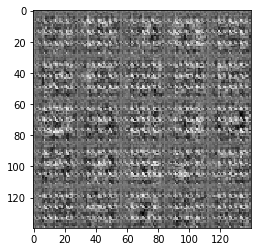

Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 0.8831
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 0.9124
Epoch 1/2... Discriminator Loss: 1.1109... Generator Loss: 0.8887
Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 0.8548
Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 0.9236
Epoch 1/2... Discriminator Loss: 1.1099... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 0.8968
Epoch 1/2... Discriminator Loss: 1.1028... Generator Loss: 0.9523
Epoch 1/2... Discriminator Loss: 1.1115... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.9756


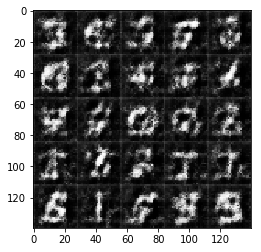

Epoch 1/2... Discriminator Loss: 1.0631... Generator Loss: 0.9940
Epoch 1/2... Discriminator Loss: 1.0956... Generator Loss: 0.9324
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 0.9312
Epoch 1/2... Discriminator Loss: 1.0541... Generator Loss: 0.9429
Epoch 1/2... Discriminator Loss: 1.0832... Generator Loss: 0.9705
Epoch 1/2... Discriminator Loss: 1.0476... Generator Loss: 0.9516
Epoch 1/2... Discriminator Loss: 1.0779... Generator Loss: 0.9694
Epoch 1/2... Discriminator Loss: 1.0480... Generator Loss: 0.9739
Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 0.9909
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 1.0120


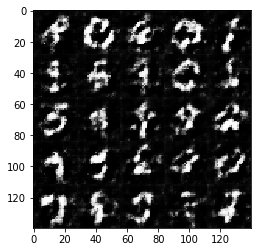

Epoch 1/2... Discriminator Loss: 1.0251... Generator Loss: 0.9820
Epoch 1/2... Discriminator Loss: 0.9114... Generator Loss: 1.0673
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 0.9832
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 0.9998
Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 1.0693
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 0.9578
Epoch 2/2... Discriminator Loss: 0.9931... Generator Loss: 1.0448
Epoch 2/2... Discriminator Loss: 1.0630... Generator Loss: 0.9467
Epoch 2/2... Discriminator Loss: 0.9767... Generator Loss: 1.0464
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 1.0365


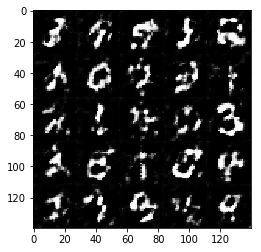

Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 1.0362
Epoch 2/2... Discriminator Loss: 1.0319... Generator Loss: 0.9619
Epoch 2/2... Discriminator Loss: 0.9849... Generator Loss: 1.0309
Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 0.9778
Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: 0.9725
Epoch 2/2... Discriminator Loss: 0.9682... Generator Loss: 1.0240
Epoch 2/2... Discriminator Loss: 1.0133... Generator Loss: 0.9356
Epoch 2/2... Discriminator Loss: 0.9561... Generator Loss: 1.0015
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 0.9946
Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 1.0205


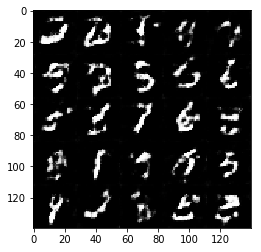

Epoch 2/2... Discriminator Loss: 0.9185... Generator Loss: 1.1189
Epoch 2/2... Discriminator Loss: 0.9784... Generator Loss: 0.9964
Epoch 2/2... Discriminator Loss: 1.0454... Generator Loss: 0.9633
Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 1.1274
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 1.0488
Epoch 2/2... Discriminator Loss: 0.9099... Generator Loss: 1.1025
Epoch 2/2... Discriminator Loss: 1.0569... Generator Loss: 0.9485
Epoch 2/2... Discriminator Loss: 1.0641... Generator Loss: 1.0809
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 1.0182
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 1.1949


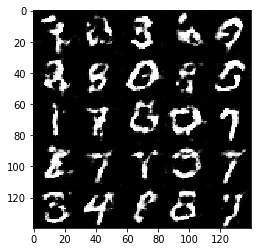

Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 0.9697
Epoch 2/2... Discriminator Loss: 0.9984... Generator Loss: 1.0006
Epoch 2/2... Discriminator Loss: 1.0448... Generator Loss: 0.9883
Epoch 2/2... Discriminator Loss: 0.8395... Generator Loss: 1.1167
Epoch 2/2... Discriminator Loss: 0.9984... Generator Loss: 1.0582
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 1.0279
Epoch 2/2... Discriminator Loss: 0.8250... Generator Loss: 1.1662
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 1.1704
Epoch 2/2... Discriminator Loss: 0.8285... Generator Loss: 1.2171
Epoch 2/2... Discriminator Loss: 0.8625... Generator Loss: 1.1392


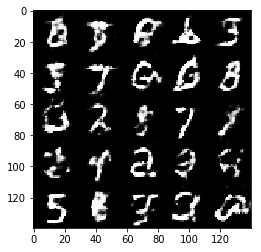

Epoch 2/2... Discriminator Loss: 0.8265... Generator Loss: 1.1285
Epoch 2/2... Discriminator Loss: 0.8206... Generator Loss: 1.2000
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 1.1729
Epoch 2/2... Discriminator Loss: 0.9207... Generator Loss: 1.1218
Epoch 2/2... Discriminator Loss: 0.8768... Generator Loss: 1.1511
Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 1.1216
Epoch 2/2... Discriminator Loss: 0.6977... Generator Loss: 1.3536
Epoch 2/2... Discriminator Loss: 0.7625... Generator Loss: 1.3622
Epoch 2/2... Discriminator Loss: 0.9284... Generator Loss: 1.1458


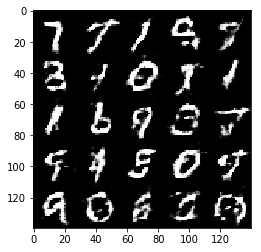

Epoch 2/2... Discriminator Loss: 0.8598... Generator Loss: 1.2371
Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 1.0234
Epoch 2/2... Discriminator Loss: 0.7538... Generator Loss: 1.3148


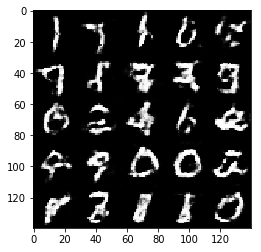


Finished


In [262]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.8876


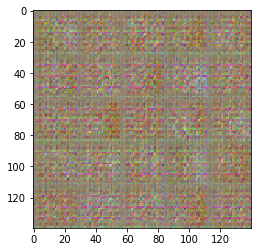

Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 1.0257
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.9420


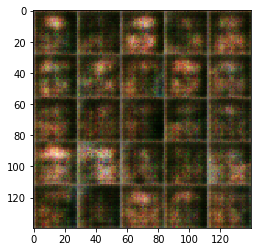

Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8048


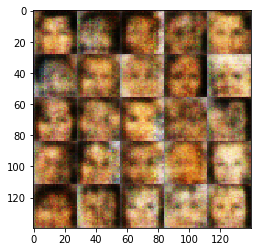

Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.8145


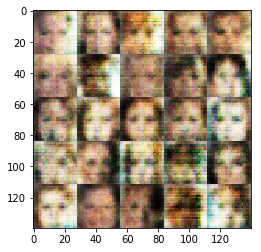

Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.7809


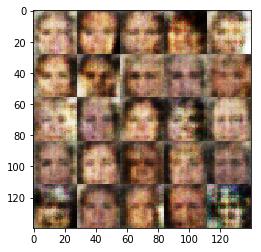

Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.8146


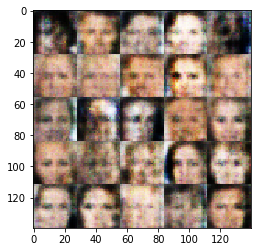

Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7756


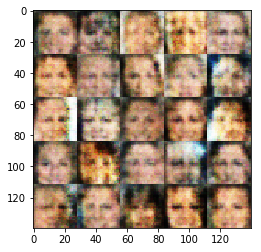

Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7429


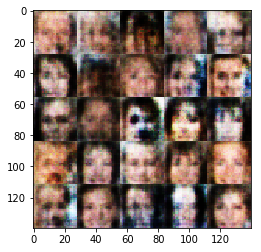

Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.7666


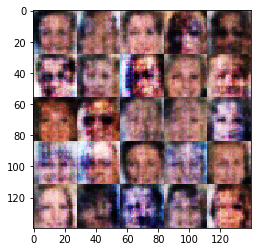

Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.7510


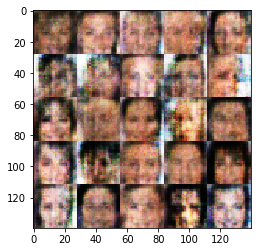

Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.8311


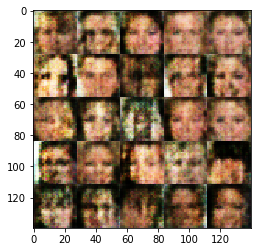

Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.8742


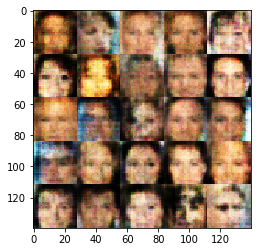

Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7155


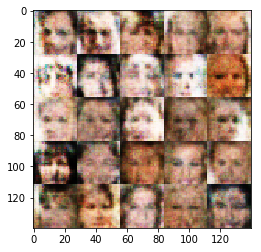

Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.8632


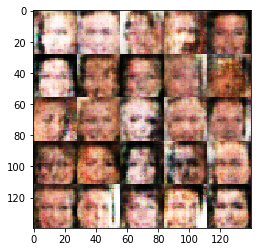

Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7275


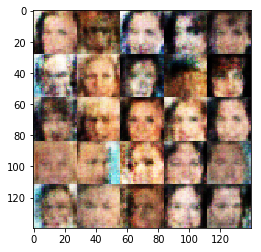

Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8075


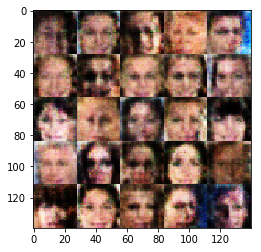


Finished


In [261]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.